# Fine tune a checkpoint of MedSAM on point prompted Data

Given a path to a MedSAM checkpoint, we want to fine tune it on pre-processed data
(subject to modifications specified by the paper and the transformation script). This will
be done initially on an anatomy-specific level.

## Argparse Setup

In [23]:
# Imports
import os
import sys
import torch
import numpy as np
from matplotlib import pyplot as plt

# Add the setup_data_vars function as we will need it to find the directory for the training data.
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '..'))
if not dir1 in sys.path: sys.path.append(dir1)

from utils.environment import setup_data_vars
setup_data_vars()

dir2 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '0_utils'))
if not dir2 in sys.path: sys.path.append(dir2)

from dataset import SAM_Dataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [24]:
anatomy = 'CTVn'
# patient_id = 28
# slice_number = 232
# axis = 1

lowres = True
save_dir = os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', anatomy)
checkpoint_path = os.path.join(os.environ['PROJECT_DIR'], 'models', 'MedSAM', 'work_dir', 'MedSAM', 'medsam_vit_b.pth')
model_path = os.path.join(save_dir, 'checkpoint_best.pth')
data_split = os.path.join(save_dir, 'data_splits.json')
img_dir = os.path.join(os.environ.get('MedSAM_preprocessed_lowres'), 'imgs')
gt_dir = os.path.join(os.environ.get('MedSAM_preprocessed_lowres'), 'gts', anatomy)
batch_size = 1
num_workers = 16

use_boxes = True
use_positive_points = False

assert os.path.exists(model_path), f"Model path {model_path} does not exist."
assert os.path.exists(data_split), f"Data split {data_split} does not exist."
assert os.path.exists(img_dir), f"Raw data {img_dir} does not exist."
assert os.path.exists(gt_dir), f"Ground truth data {gt_dir} does not exist."

In [25]:
# setup dataset
dataset = SAM_Dataset(img_dir, gt_dir, list(range(0, 101)))

Dataset size (32.9 GiB) exceeds cache limit (20 GiB). Allocating space to cache 20479 / 33680 samples.


## Set up Fine-Tuning nn Module

In [26]:
from medsam_model import MedSAM
from checkpoint_handler import CheckpointHandler

In [46]:
cph = CheckpointHandler(save_dir, checkpoint_path, device)
if cph.checkpoint_exists():
    model_finetuned, _, epoch, _ = cph.load_checkpoint()
    print(f'Loaded the model for anatomy {anatomy} from epoch {epoch}')

model_ootb, _ = cph.load_base_checkpoint()
print('Loaded base model')

Loaded the model for anatomy CTVn from epoch 101
Loaded base model


## Load up the specific example from the dataset

In [28]:
# patient_id = 4
# slice_number = 145
# axis = 0

patient_id = 57 # 28
slice_number = 264 # 232
axis = 1

batch = dataset.get_specific_sample(patient_id, axis, slice_number)

In [29]:
from torch.utils.data import DataLoader

dl = DataLoader(dataset, batch_size=1, num_workers=num_workers, shuffle=True)
dl = iter(dl)

In [40]:
def predict_image(model, batch):
    image = batch["image"].to(device)
    gt2D = batch["gt2D"].to(device)

    if len(image.shape) == 3:
        image = image.unsqueeze(0)
        gt2D = gt2D.unsqueeze(0)

    # coords_torch = batch["coords"].squeeze().to(device) # ([B, Ps, 2])
    boxes_torch = batch["boxes"].squeeze().reshape(batch_size, -1, 4).to(device) # ([B, Ps, 4])

    medsam_preds = []
    medsam_segs = []

    for b in torch.unique(boxes_torch.squeeze().reshape(-1, batch_size, 4), dim=0):
        b = b.reshape(batch_size, 1, 4)
        print(b, b.shape)
        medsam_lite_pred = model(image, None, b)
        medsam_seg_prob = torch.sigmoid(medsam_lite_pred)
        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

        medsam_preds.append(medsam_lite_pred.detach().cpu())
        medsam_segs.append(medsam_seg)

    medsam_preds = torch.tensor(np.stack(medsam_preds))
    medsam_segs = torch.tensor(np.stack(medsam_segs))

    # do an OR operation on the medsam_segs
    medsam_seg = medsam_segs.sum(dim=0)

    return medsam_seg

tensor([[[348., 278., 628., 538.]]], device='cuda:0') torch.Size([1, 1, 4])
tensor([[[348., 278., 628., 538.]]], device='cuda:0') torch.Size([1, 1, 4])


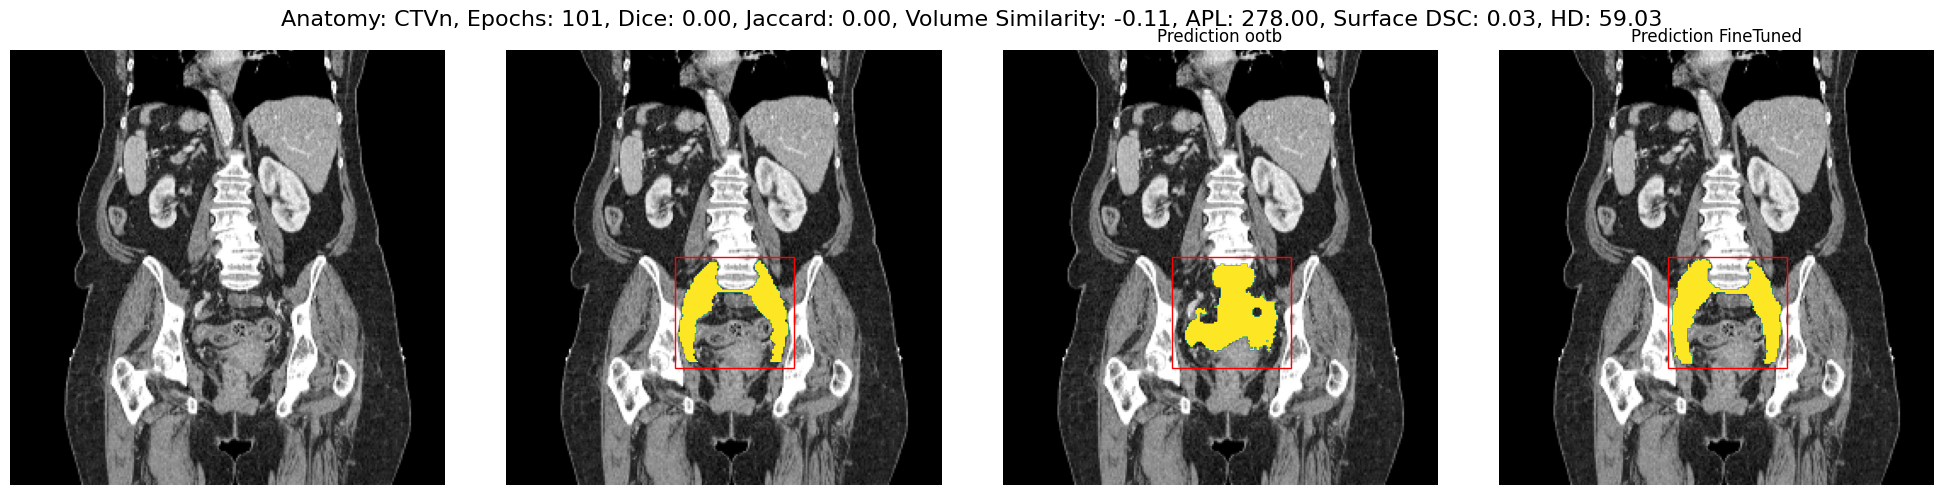

In [48]:
# axis 1, [260, 276]
# axis 2, [226, 249]

# for slice_number in range(20):

    # batch = dataset.get_specific_sample(patient_id, axis, slice_number)
    # batch = next(dl)

# FOR A RANDOM BATCH OF 1
image = batch["image"].to(device)
gt2D = batch["gt2D"].to(device)
boxes_torch = batch["boxes"].squeeze().reshape(batch_size, -1, 4).to(device) # ([B, Ps, 4])

if len(image.shape) == 3:
    image = image.unsqueeze(0)
    gt2D = gt2D.unsqueeze(0)

medsam_seg_finetuned = predict_image(model_finetuned, batch)
medsam_seg_ootb = predict_image(model_ootb, batch)

import torch.nn.functional as F

# convert tensor to cpu
image_cpu = image.detach().cpu()
pred_cpu_finetuned = medsam_seg_finetuned
pred_cpu_ootb = medsam_seg_ootb
gt_cpu = gt2D.detach().cpu()

images = F.interpolate(image_cpu, size=(256, 256), mode='bilinear', align_corners=False)

nrows = batch_size
ncols = 4 # image, gt, pred

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 5))
# reshape axes object
ax = ax.reshape(nrows, ncols)

for i in range(nrows):

    ct_slice = images[i, 0]
    ground_truth = gt_cpu[i, 0]

    if axis != 0:
        ct_slice = torch.flip(ct_slice, [0, 1])
        ground_truth = torch.flip(ground_truth, [0, 1])
        pred_cpu_finetuned = torch.flip(pred_cpu_finetuned, [0, 1])
        pred_cpu_ootb = torch.flip(pred_cpu_ootb, [0, 1])

    ax[i, 0].imshow(ct_slice, cmap='gray')
    ax[i, 0].axis('off')

    ax[i, 1].imshow(ct_slice, cmap='gray')
    ax[i, 1].imshow(ground_truth, cmap='viridis', alpha=np.where(ground_truth > 0, 1, 0).astype(np.float32))
    ax[i, 1].axis('off')

    # display the boxes used
    for b in torch.unique(boxes_torch.squeeze().reshape(-1, batch_size, 4), dim=0):
        box = b.reshape(batch_size, 1, 4).squeeze().cpu().numpy()
        x_min, y_min, x_max, y_max = box
        x_min, y_min, x_max, y_max = x_min * 256 / 1024, y_min * 256 / 1024, x_max * 256 / 1024, y_max * 256 / 1024

        if axis != 0:
            y_min = 256 - y_min
            y_max = 256 - y_max
            x_min = 256 - x_min
            x_max = 256 - x_max

        rectangle = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, edgecolor='r', facecolor='none')
        ax[i, 1].add_patch(rectangle)
        rectangle = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, edgecolor='r', facecolor='none')
        ax[i, 2].add_patch(rectangle)
        rectangle = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, edgecolor='r', facecolor='none')
        ax[i, 3].add_patch(rectangle)

    ax[i, 2].imshow(ct_slice, cmap='gray')
    ax[i, 2].imshow(pred_cpu_ootb, cmap='viridis', alpha=np.where(pred_cpu_ootb> 0, 1, 0).astype(np.float32))
    ax[i, 2].axis('off')
    ax[i, 2].set_title(f'Prediction ootb')

    ax[i, 3].imshow(ct_slice, cmap='gray')
    ax[i, 3].imshow(pred_cpu_finetuned, cmap='viridis', alpha=np.where(pred_cpu_finetuned> 0, 1, 0).astype(np.float32))
    ax[i, 3].axis('off')
    ax[i, 3].set_title(f'Prediction FineTuned')

import SimpleITK as sitk
from platipy.imaging.label.comparison import compute_metric_total_apl, compute_surface_dsc, compute_metric_hd

y_gt_sitk = sitk.GetImageFromArray(gt_cpu[0].numpy().astype(np.uint8))
ypred_sitk = sitk.GetImageFromArray(pred_cpu_finetuned[None, :, :].numpy().astype(np.uint8))

overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
overlap_measures_filter.Execute(y_gt_sitk, ypred_sitk)
            
dice = overlap_measures_filter.GetDiceCoefficient()
jaccard = overlap_measures_filter.GetJaccardCoefficient()
volume_similarity = overlap_measures_filter.GetVolumeSimilarity()

apl = compute_metric_total_apl(y_gt_sitk, ypred_sitk)
surface_dsc = compute_surface_dsc(y_gt_sitk, ypred_sitk)
hd = compute_metric_hd(y_gt_sitk, ypred_sitk)

plt.suptitle(f'Anatomy: {anatomy}, Epochs: {epoch}, Dice: {dice:.2f}, Jaccard: {jaccard:.2f}, Volume Similarity: {volume_similarity:.2f}, APL: {apl:.2f}, Surface DSC: {surface_dsc:.2f}, HD: {hd:.2f}', fontsize=16)

plt.tight_layout()
plt.show()